In [1]:
import sys
sys.path.append('../')

import pandas as pd
import os
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sim_df = pd.read_pickle('s3://aztec-gddt/psuu_run_2024-05-02T225337Z/timestep_tensor-0.pkl.zip')

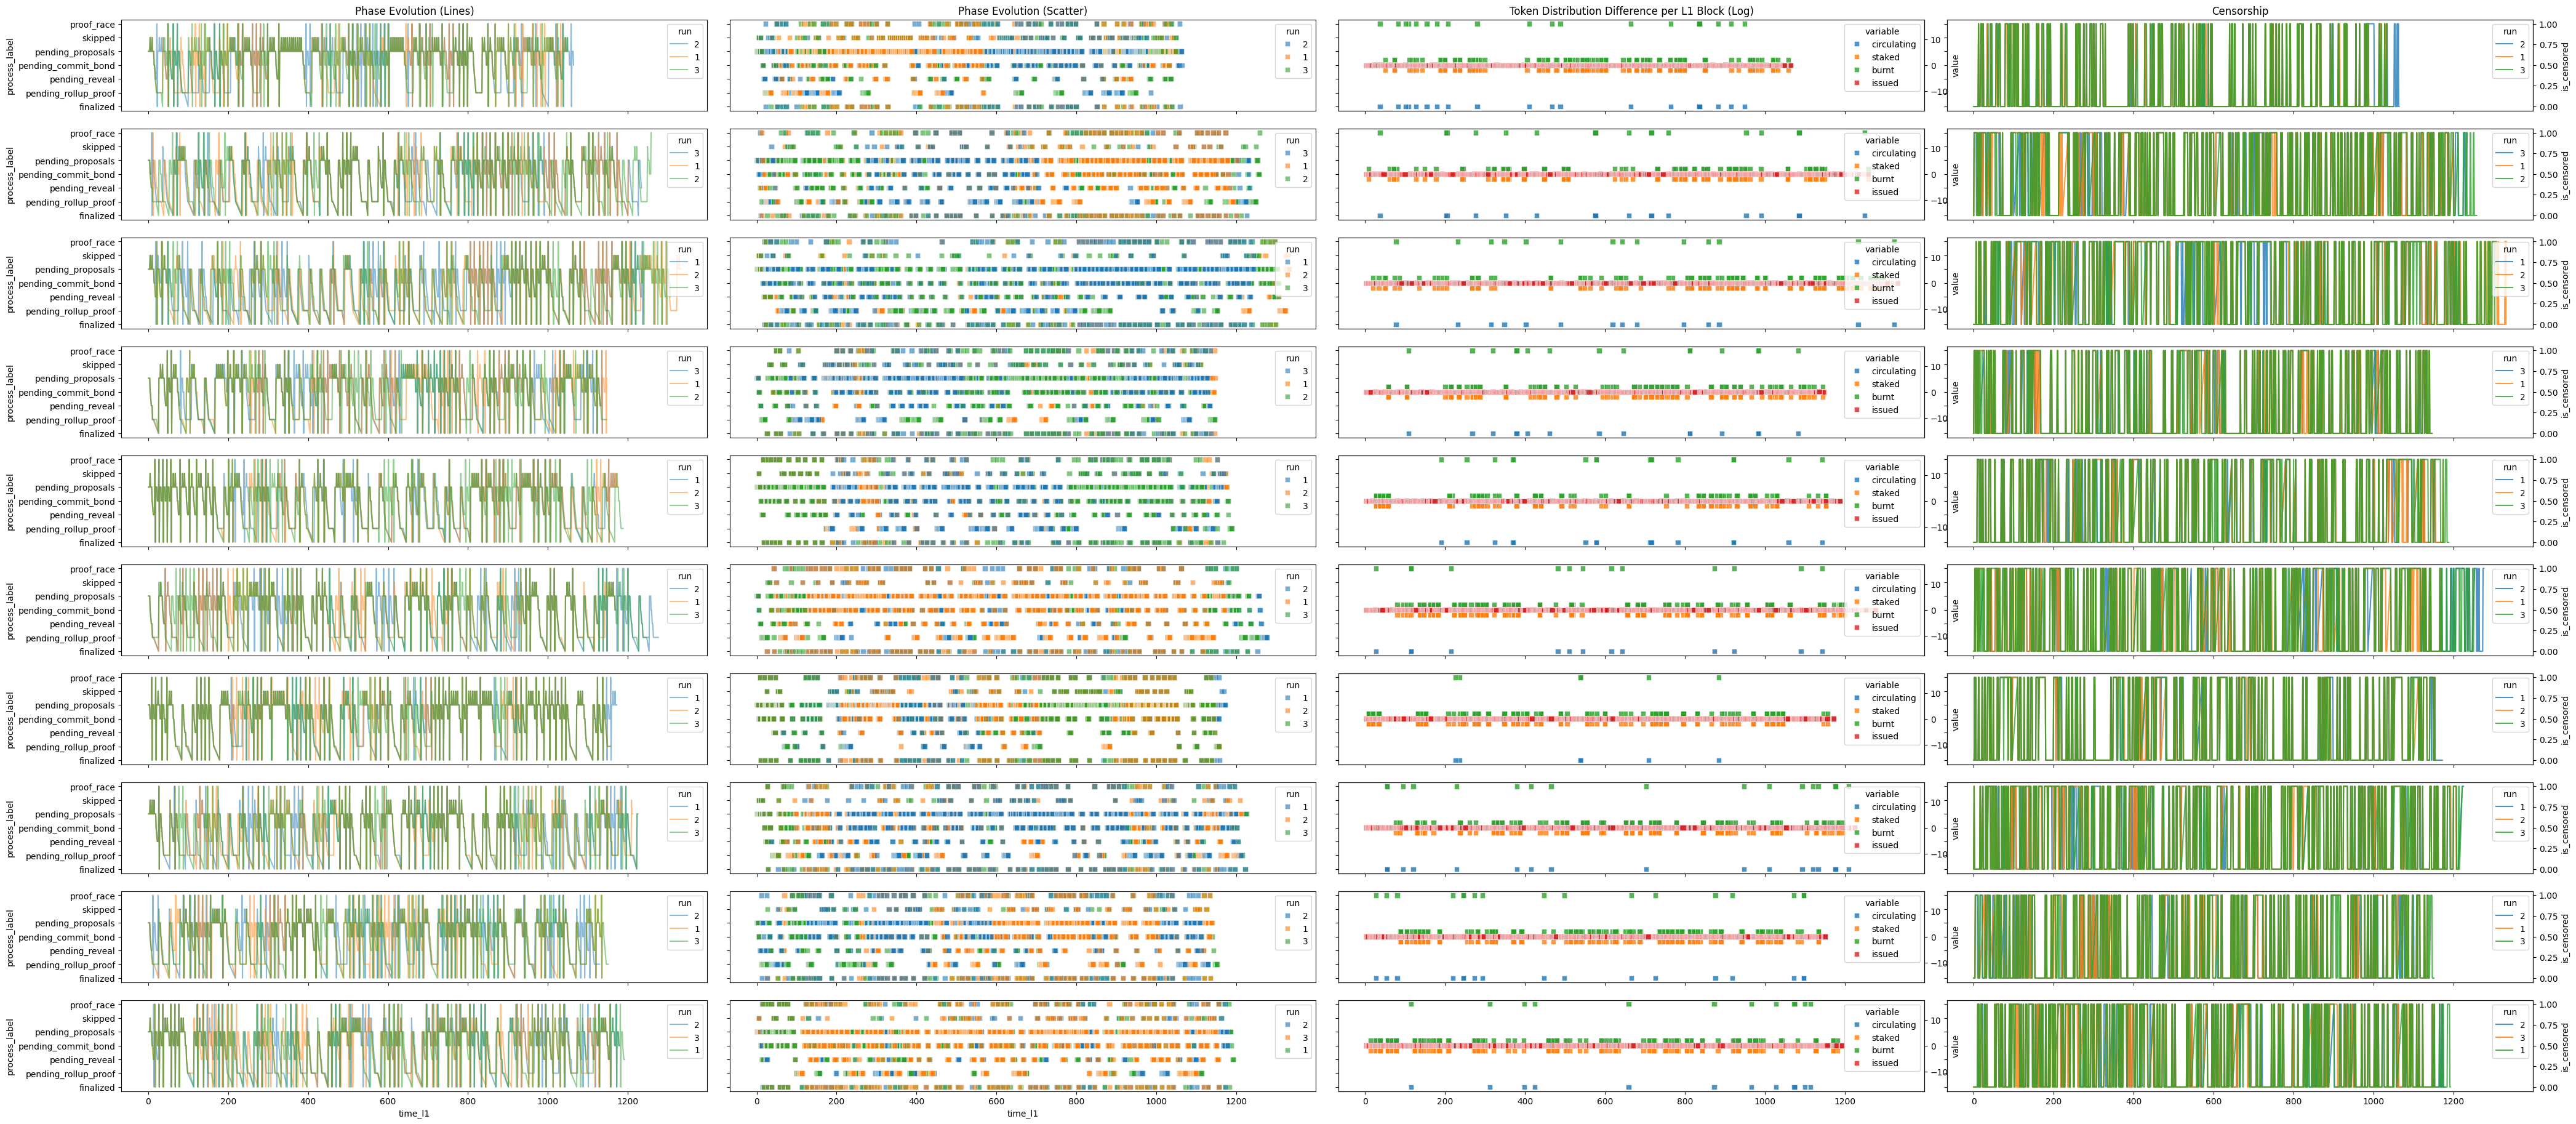

In [5]:
N_subsets = 10
N_cols = 4
size_per_col = 10.0
size_per_row = 1.8


fig, axes = plt.subplots(nrows=N_subsets, ncols=N_cols, figsize=(N_cols*size_per_col, N_subsets*size_per_row), sharey=True, sharex=True)
fig.tight_layout()
for i in range(N_subsets):
    traj_df = sim_df.query(f"subset == {i} & run <= 3")

    fig_df = traj_df.copy()
    fig_df['process_order'] = fig_df.current_process.map(lambda x: x.phase.value if x is not None else None)
    fig_df['process_label'] = fig_df.current_process.map(lambda x: x.phase.name if x is not None else None)
    fig_df = fig_df.sort_values(['process_order', 'timestep'])#.query("time_l1 > 320 & time_l1 < 370")


    sns.lineplot(x=fig_df.time_l1, 
                y=fig_df.process_label,
                hue=fig_df.run.astype(str),
                alpha=0.5,
                ax=axes[i][0]
                )

    sns.scatterplot(x=fig_df.time_l1, 
                y=fig_df.process_label,
                hue=fig_df.run.astype(str),
                marker='s',
                alpha=0.6,
                ax=axes[i][1])
    
    id_cols = ['time_l1', 'run']
    ts_df = traj_df.set_index(id_cols).token_supply.apply(lambda x: pd.Series(x.__dict__)).diff().query("time_l1 > 1")


    melted_df = ts_df.reset_index().melt(id_vars=id_cols)
    ax1 = axes[i][2].twinx()
    sns.scatterplot(x=melted_df.time_l1,
                 y=melted_df.value,
                 #style=melted_df.run.astype(str),
                 hue=melted_df.variable,
                 alpha=0.8,
                 marker='s',
                 ax=ax1)
    
    ax1.set_yscale = 'symlog'

    ax1 = axes[i][3].twinx()
    sns.lineplot(x=fig_df.time_l1, 
                y=fig_df.is_censored,
                hue=fig_df.run.astype(str),
                alpha=0.8,
                ax=ax1
                )

axes[0][0].set_title('Phase Evolution (Lines)')
axes[0][1].set_title('Phase Evolution (Scatter)')
axes[0][2].set_title('Token Distribution Difference per L1 Block (Log)')
axes[0][3].set_title('Censorship')
plt.show()